## 1. Import Modules

In [1]:
import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots
sns.set_theme('talk', style = 'white')


## 2. Data Collection & Cleaning

### 2.1 Load Data from Excel Table

In [2]:
data = pd.read_excel('Data/pwt110_download_2025_11_24.xlsx', sheet_name = 'Data', header = 0)

### 2.2 Clean Data

#### 2.2.1  Construct Price Index for Scaling

In [3]:
# Define price index
data["price_index"] = data["cgdpe"] / data["rgdpe"]
# Calculate the price index of 2017 and 2021
P_2017 = (
    data.loc[data["year"] == 2017, ["country", "price_index"]]
    .set_index("country")
)

P_2021 = (
    data.loc[data["year"] == 2021, ["country", "price_index"]]
    .set_index("country")
)

#### 2.2.2 Filter Data and Change the Base Year from 2021 to 2017

In [4]:
# Filter data by columns. We need country, year, real gdp, population, real capital, human capital and employment)
data_filtered = data.loc[:, ("country", "year", "rgdpe", "pop","rnna", "hc", "emp")]
#Drop empty values
data_filtered = data_filtered.dropna(subset=["rgdpe", "pop"])

# Calculate real dgp per person
data_filtered["rgdpe_pc"] = data_filtered["rgdpe"] / data_filtered["pop"]

# select Chile as a country
data_Chile = data_filtered.loc[data_filtered["country"] == "Chile"].copy()
# Changing base year 2021 to 2017 of rdgpe, rnna, and rgdpe_pc
scale = (
    P_2021.loc["Chile", "price_index"] /
    P_2017.loc["Chile", "price_index"]
)

cols_to_rebase = ["rgdpe", "rnna","rgdpe_pc"]

for col in cols_to_rebase:
    data_Chile[col] = data_Chile[col]*scale
# Reset the index
data_Chile = data_Chile.reset_index(drop = True)

In [5]:
# Subset the RGDP per capita series
ymax = 2023
ymin = 1951 # Starting at 1951 because data for Chile in 1950 is unavailable.

# We use logical indexing to subset the data to rows of years ymin <= year <= ymax
Y = data_Chile.loc[np.logical_and(data_Chile["year"] <= ymax, data_Chile["year"] >= ymin), "rgdpe_pc"]
y = np.log(Y)
data_Chile = data_Chile[data_Chile["year"] >= ymin] # we keep only years after ymin

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T = len(Y) # sample size used for regression
T_all = data_Chile["year"].max() - (ymin - 1) # number of all years in the data after ymin

## 3. Compute different trend specifications

In [6]:
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is vector 1, 4, 9, ..., T^2.
# The dependent variable is per capita GDP in *levels*

x1 = np.empty(T) # initialise an empty vector for the first regressor
x2 = np.empty(T) # initialise an empty vector for the second regressor
x3 = np.empty(T) #initialise an empty vector for the third regressor

for t in range(T):
    x1[t] = 1.
    x2[t] = t + 1 # recall that Python starts indexing at 0
    x3[t] = (t + 1)**2


### 3.1 Additive Linear Model

In [9]:
# Model: Yt = a + bt
a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)

In [10]:
# Initialise predicted values yhat
Yhat_add_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1) # recall that Python indexing starts at 0

# Let us convert into log-units
yhat_add_lin = np.log(Yhat_add_lin)

Text(0.5, 1.0, 'Linear Additive: GDP & trend')

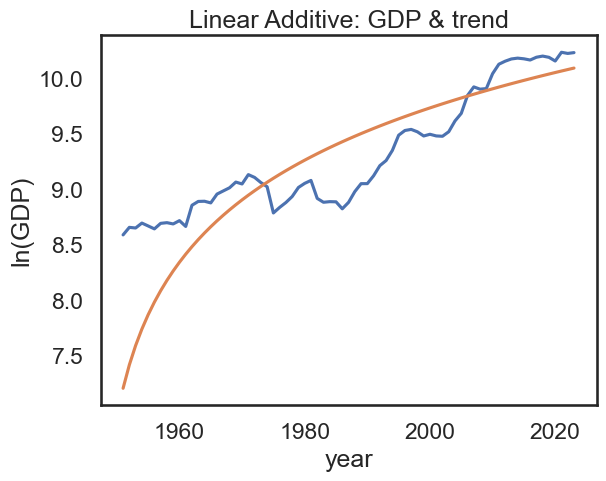

In [11]:
lw = 4
plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(data_Chile['year'],np.log(data_Chile['rgdpe_pc']))
plt.plot(data_Chile['year'],yhat_add_lin)

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Linear Additive: GDP & trend")


### 3.2 Additive Quadratic Model

In [12]:
# Model: Yt = a + bt + ct^2
a_add_qua, b_add_qua, c_add_qua = get_regression_coefs(Y, x1, x2, x3)

In [13]:
# Initialise predicted values yhat
Yhat_add_qua= np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    Yhat_add_qua[t] = a_add_qua + b_add_qua * (t + 1) + c_add_qua * (t + 1)**2

# Let us convert into log-units
yhat_add_qua = np.log(Yhat_add_qua)

Text(0.5, 1.0, 'Additive Quadratic: GDP & trend')

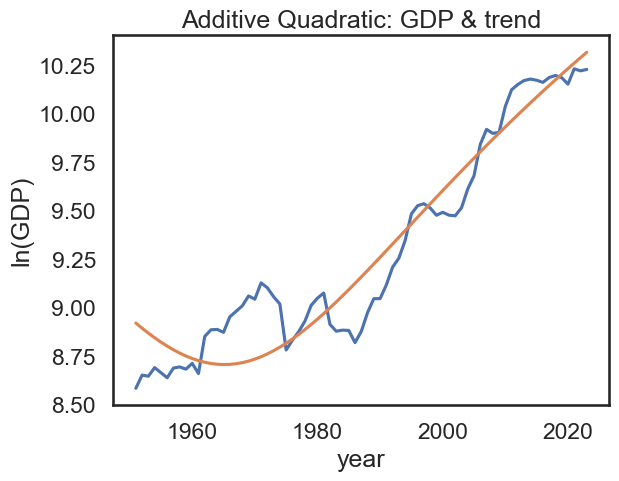

In [14]:
lw = 4
plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(data_Chile['year'],np.log(data_Chile['rgdpe_pc']))
plt.plot(data_Chile['year'],yhat_add_qua)

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Additive Quadratic: GDP & trend")


### 3.3  Exponential  Linear Model

In [15]:
# Model: log(Yt) = a + bt (y = log(Y))
a_exp_lin, b_exp_lin = get_regression_coefs(y, x1, x2)

In [16]:
# Initialise predicted values yhat
yhat_exp_lin = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)


Text(0.5, 1.0, 'Exponential Linear: GDP & trend')

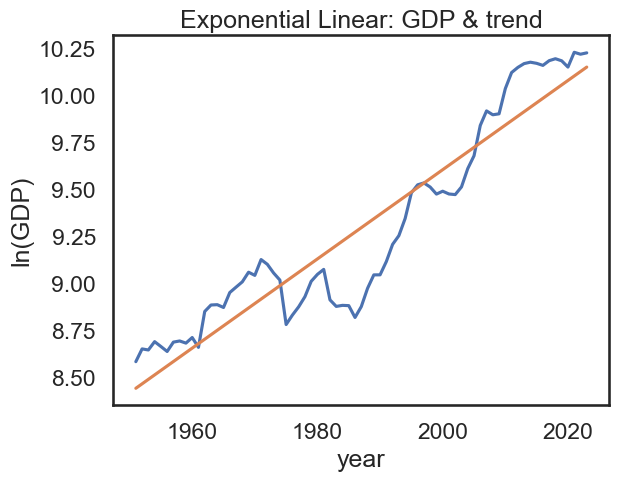

In [17]:
lw = 4
plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(data_Chile['year'],np.log(data_Chile['rgdpe_pc']))
plt.plot(data_Chile['year'],yhat_exp_lin)

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Exponential Linear: GDP & trend")


### 3.4 Exponential Quadratic Model

In [18]:
# Model: log(Yt) = a + bt + ct^2
a_exp_qua, b_exp_qua, c_exp_qua = get_regression_coefs(y, x1, x2, x3)

In [19]:
# Initialise predicted values yhat
yhat_exp_qua = np.empty(T_all)

# Create loop to compute trend for all years
for t in range(T_all):
    yhat_exp_qua[t] = a_exp_qua + b_exp_qua * (t + 1) + c_exp_qua * (t + 1)**2


Text(0.5, 1.0, 'Exponential Quadratic: GDP & trend')

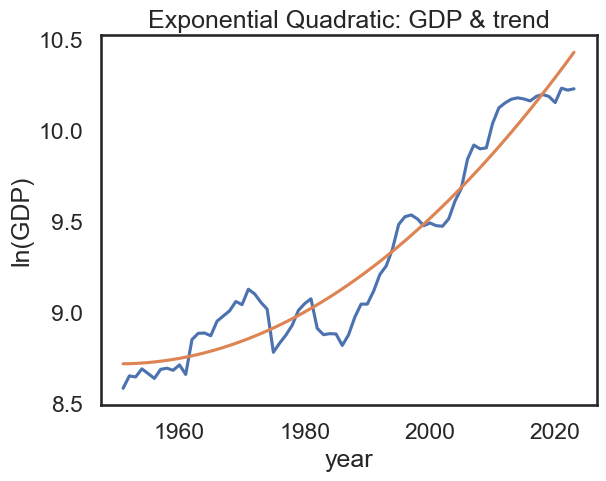

In [20]:
lw = 4
plt.figure()
#one could add options such as a particular size and use instead
#plt.figure(figsize=(7, 5))
plt.plot(data_Chile['year'],np.log(data_Chile['rgdpe_pc']))
plt.plot(data_Chile['year'],yhat_exp_qua)

#labels
plt.xlabel("year")
plt.ylabel("ln(GDP)")

#title
plt.title("Exponential Quadratic: GDP & trend")
